In [7]:
import pylab as pl
import numpy as np
import scipy as sp
from numpy.linalg import eig
from scipy.io import loadmat
import pdb

In [8]:
def load_data(fname):
    # load the data
    data = loadmat(fname)
    # extract images and labels
    X = data['X']
    Y = data['Y']
    # collapse the time-electrode dimensions
    X = np.reshape(X,(X.shape[0]*X.shape[1],X.shape[2]))
    # transform the labels to (-1,1)
    Y = np.sign((Y[0,:]>0) -.5)
    # pick only first 500 (1000, 3000) datapoints and compare optimal shrinkage
    X = X[:, :500]
    Y = Y[:500]
    print(X.shape)
    return X,Y

In [9]:
def crossvalidate_nested(X,Y,f,gammas):
    ''' 
    Optimize shrinkage parameter for generalization performance 
    Input:	X	data (dims-by-samples)
                Y	labels (1-by-samples)
                f	number of cross-validation folds
                gammas	a selection of shrinkage parameters
                trainfunction 	trains linear classifier, returns weight vector and bias term
    '''
    # the next two lines reshape vector of indices in to a matrix:
    # number of rows = # of folds
    # number of columns = # of total data-points / # folds
    N = f*int(np.floor(X.shape[-1]/f))
    idx = np.reshape(np.arange(N),(f,int(np.floor(N/f))))
    pdb.set_trace()
    acc_test = np.zeros((f))
    testgamma = np.zeros((gammas.shape[-1],f))
    
    # loop over folds:
    # select one row of 'idx' for testing, all other rows for training
    # call variables (indices) for training and testing 'train' and 'test'
    for ifold in np.arange(f):
        test=idx[ifold, :]
        train=idx[np.arange(f) != ifold, :].flatten()
        
        # loop over gammas
        for igamma in range(gammas.shape[-1]):
            # each gamma is fed into the inner CV via the function 'crossvalidate_lda'
            # the resulting variable is called 'testgamma'
            testgamma[igamma,ifold] =crossvalidate_lda(X[:,train],Y[train],f-1,gammas[igamma])
        # find the the highest accuracy of gammas for a given fold and use it to train an LDA on the training data
        hgamma_idx=testgamma[:,ifold].argmax()
        hgamma =gammas[hgamma_idx]
        w,b = train_lda(X[:,train],Y[train],hgamma)
        # calculate the accuracy for this LDA classifier on the test data
        pred=np.sign(w.dot(X[:,test]) -b)
        acc_test[ifold] = (pred ==Y[test]).mean()

    # do some plotting
    pl.figure()
    pl.boxplot(testgamma.T)
    pl.xticks(np.arange(gammas.shape[-1])+1,gammas)
    pl.xlabel('$\gamma$')
    pl.ylabel('Accuracy')
    pl.savefig('cv_nested-boxplot.pdf')

    return acc_test,testgamma

In [10]:
def crossvalidate_lda(X,Y,f,gamma):
    ''' 
    Test generalization performance of shrinkage lda
    Input:	X	data (dims-by-samples)
                Y	labels (1-by-samples)
                f	number of cross-validation folds
                trainfunction 	trains linear classifier, returns weight vector and bias term
    '''
    N = f*int(np.floor(X.shape[-1]/f))
    idx = np.reshape(np.arange(N),(f,int(np.floor(N/f))))
    acc_test = np.zeros((f))
    
    # loop over folds
    # select one row of idx for testing, all others for training
    # call variables (indices) for training and testing 'train' and 'test'
    for ifold in np.arange(f):
        test=idx[ifold,:]
        train=idx[np.arange(f)!=ifold, :]
        # train LDA classifier with training data and given gamma:
        w, b = train_lda(X[:, train],Y[train],gamma)
        # test classifier on test data:
        pred=np.sign(w.dot(X[:, test])-b)
        acc_test[ifold] = (pred==Y[test]).mean()
    return acc_test.mean()

In [11]:
def train_lda(X,Y,gamma):
    '''
    Train a nearest centroid classifier
    '''
    # class means
    mupos = np.mean(X[:,Y>0],axis=1)
    muneg = np.mean(X[:,Y<0],axis=1)

    # inter and intra class covariance matrices
    Sinter = np.outer(mupos-muneg,mupos-muneg)
    #Sinter = sp.outer(muneg-mupos,muneg-mupos)
    Sintra = np.cov(X[:,Y>0]) + np.cov(X[:,Y<0])
    # shrink covariance matrix estimate
    Sintra = (1 - gamma) * Sintra + gamma * (np.trace(Sintra) / Sintra.shape[0]) * np.eye(Sintra.shape[0])
    # solve eigenproblem
    eigvals, eigvecs = sp.linalg.eig(Sinter,Sintra)
    # weight vector
    w = eigvecs[:,eigvals.argmax()]
    if np. dot (w, mupos)<np.dot (w, muneg) :
        w =-w
    # offset
    b = (w.dot(mupos) + w.dot(muneg))/2.
    # return the weight vector
    return w,b

(310, 500)
> /var/folders/kp/_t4rfbss0kl95l2rb101h4_h0000gn/T/ipykernel_46208/4252259669.py(16)crossvalidate_nested()
     14     idx = np.reshape(np.arange(N),(f,int(np.floor(N/f))))
     15     pdb.set_trace()
---> 16     acc_test = np.zeros((f))
     17     testgamma = np.zeros((gammas.shape[-1],f))
     18 

[0.88 0.98 0.98 0.92 0.96 0.98 0.92 0.96 0.94 0.94]
[[0.84666667 0.8        0.80666667 0.83111111 0.82       0.76666667
  0.82666667 0.83333333 0.85777778 0.79777778]
 [0.94666667 0.93111111 0.92666667 0.93111111 0.94222222 0.92222222
  0.94888889 0.93333333 0.94       0.94      ]
 [0.95555556 0.94       0.94222222 0.95111111 0.94888889 0.93555556
  0.95111111 0.95333333 0.95777778 0.94222222]
 [0.91333333 0.91333333 0.91555556 0.90666667 0.92222222 0.89777778
  0.91111111 0.90666667 0.92       0.91555556]
 [0.66888889 0.66222222 0.65111111 0.66222222 0.66444444 0.66666667
  0.66888889 0.67555556 0.66888889 0.67333333]]


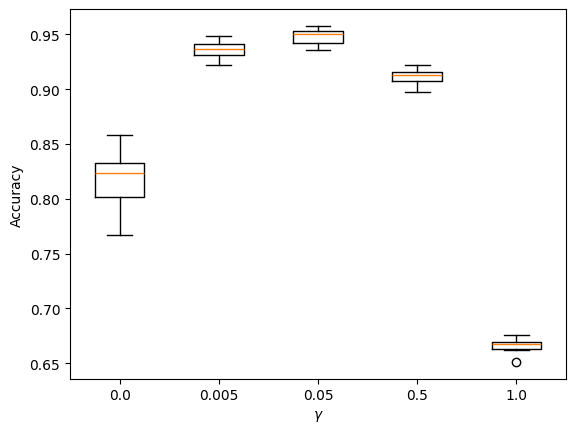

In [12]:
X,Y = load_data('bcidata.mat')
gammas=np.array([0,.005,.05,.5,1])
a,b = crossvalidate_nested(X,Y,10,gammas)
print(a)
print(b)
